<a href="https://colab.research.google.com/github/jose-cano/Deep-Learning/blob/main/NER_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://huggingface.co/datasets/ncbi_disease

Leaderboard: https://paperswithcode.com/sota/named-entity-recognition-ner-on-ncbi-disease

potential system: https://huggingface.co/datasets/rjac/biobert-ner-diseases-dataset

https://huggingface.co/alvaroalon2/biobert_chemical_ner

https://huggingface.co/alvaroalon2/biobert_genetic_ner

datasets of potential system: https://github.com/librairy/bio-ner

HF dataset object with Spark: https://huggingface.co/docs/datasets/use_with_spark

Loading text data: https://huggingface.co/docs/datasets/nlp_load

# Named Entity Recognition - Proof of Concept

Named entity recognition (NER): The task is to find the entities (such as persons, locations, or organizations) in a sentence. This can be formulated as attributing a label to each token by having one class per entity and one class for “no entity.”

Thus, it is also known as *_Token Classification_*

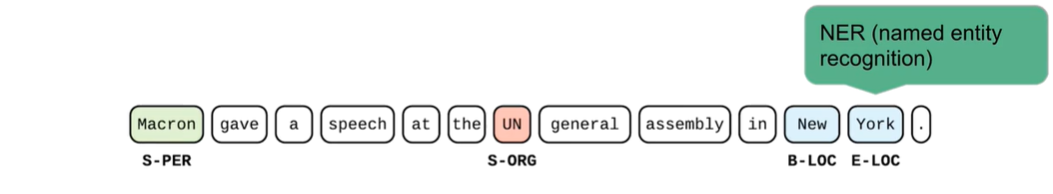

In [21]:
!pip install transformers datasets accelerate -U

In [22]:
import pandas as pd
from transformers import pipeline
from datasets import load_dataset

This dataset contains the disease name and concept annotations of the NCBI disease corpus, a collection of 793 PubMed abstracts fully annotated at the mention and concept level to serve as a research resource for the biomedical natural language processing community.

Data Fields
```
id: Sentence identifier.

tokens: Array of tokens composing a sentence.

ner_tags: Array of tags, where 0 indicates no disease mentioned, 1 signals the first token of a disease and 2 the subsequent disease tokens.

Data Splits: The data is split into a train (5433 instances), validation (924 instances) and test set (941 instances).
```

In [23]:
data = load_dataset('ncbi_disease')
data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

In [39]:
# First sample
data['train'][0]

{'id': '0',
 'tokens': ['Identification',
  'of',
  'APC2',
  ',',
  'a',
  'homologue',
  'of',
  'the',
  'adenomatous',
  'polyposis',
  'coli',
  'tumour',
  'suppressor',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]}

In [40]:
# Features, such as ner_tag labels
data['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-Disease', 'I-Disease'], id=None), length=-1, id=None)}

In [ ]:
# Notice punctuation
" ".join(['Identification',  'of',  'APC2',  ',',  'a',  'homologue',  'of',  'the',  'adenomatous',  'polyposis',  'coli',  'tumour',  'suppressor',  '.'],)

'Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .'

In [41]:
# After we've loaded in a dataset, we should tokenize it
# Example of tokenizing inputs that have already been split into words (and labeled, so this will cause missalignment)
from transformers import AutoTokenizer


checkpoint = "distilbert-base-cased"
#checkpoint = "dmis-lab/biobert-base-cased-v1.2"
#checkpoint = "emilyalsentzer/Bio_ClinicalBERT"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# example
tokenized_1 = tokenizer(data['train'][0]['tokens'], is_split_into_words=True)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
tokenized_1

{'input_ids': [101, 146, 11951, 5783, 1104, 10997, 1658, 1477, 117, 170, 16358, 3702, 12733, 1104, 1103, 8050, 26601, 21943, 2285, 185, 23415, 5674, 4863, 1884, 2646, 189, 27226, 17203, 1766, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Because we've tokenized some words into subwords, the input sequence may end up being longer than the target sequence.

We need to align the targets with the inputs in order for our model to learn how to tag properly.

For any input word that was split into a subword, we assign the same target. By the end of this process, the length of inputs should be the same as the length of targets.

Also note, tumor vs tumour.
```
'tumour' -> Disease

't' -> B-Disease

'##umour' -> I-Disease
```

In BERT architectures, the [CLS] and [SEP] tokens are legitimate tokens that go into the model as inputs. Thus, they also need a specific label. The documentation specifies these tokens should have a label of -100 for the model to ignore them.

https://huggingface.co/docs/transformers/tasks/token_classification

In [42]:
print(tokenized_1.tokens()),
print(tokenized_1.word_ids())

['[CLS]', 'I', '##dent', '##ification', 'of', 'AP', '##C', '##2', ',', 'a', 'ho', '##mo', '##logue', 'of', 'the', 'ad', '##eno', '##mat', '##ous', 'p', '##oly', '##po', '##sis', 'co', '##li', 't', '##umour', 'suppress', '##or', '.', '[SEP]']
[None, 0, 0, 0, 1, 2, 2, 2, 3, 4, 5, 5, 5, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 12, 12, 13, None]


In [ ]:
data['train'][0]['ner_tags']

[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]

In [32]:
# Recall ['O', 'B-Disease', 'I-Disease']
# Zero is not needed
begin2inside = {
    1:2,
}

In [ ]:
# Conceptually

word_ids = [None, 0, 0, 0, 1, 2, 2, 2, 3, 4, 5, 5, 5, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 12, 12, 13, None]
labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]

In [36]:
def align_targets(labels, word_ids):

  aligned_labels = []
  last_word = None

  for word in word_ids:

    if word is None: # [CLS] or [SEP] tokens
      label = -100

    elif word != last_word: # New word (word ID different from previous)
      label = labels[word]

    else: # Same word as before
      label = labels[word]

      if label in begin2inside:
        label = begin2inside[label]

    aligned_labels.append(label) # Add the label
    last_word = word # Update last word

  return aligned_labels

In [43]:
# try our function
idx = 0
labels = data['train'][idx]['ner_tags']
word_ids = tokenized_1.word_ids()
aligned_targets = align_targets(labels, word_ids)
print(aligned_targets)

[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, -100]


In [44]:
label_names = data["train"].features['ner_tags'].feature.names
aligned_labels = [label_names[t] if t >= 0 else None for t in aligned_targets]
for x, y in zip(tokenized_1.tokens(), aligned_labels):
  print(f"{x}\t{y}")

[CLS]	None
I	O
##dent	O
##ification	O
of	O
AP	O
##C	O
##2	O
,	O
a	O
ho	O
##mo	O
##logue	O
of	O
the	O
ad	B-Disease
##eno	I-Disease
##mat	I-Disease
##ous	I-Disease
p	I-Disease
##oly	I-Disease
##po	I-Disease
##sis	I-Disease
co	I-Disease
##li	I-Disease
t	I-Disease
##umour	I-Disease
suppress	O
##or	O
.	O
[SEP]	None


In [45]:
# tokenize both inputs and align targets
def tokenize_fn(batch):
  # tokenize the input sequence first
  # this populates input_ids, attention_mask, etc.
  tokenized_inputs = tokenizer(
    batch['tokens'], truncation=True, is_split_into_words=True
  )

  labels_batch = batch['ner_tags'] # original targets
  aligned_labels_batch = []
  for i, labels in enumerate(labels_batch):
    word_ids = tokenized_inputs.word_ids(i)
    aligned_labels_batch.append(align_targets(labels, word_ids))

  # recall: the 'target' must be stored in key called 'labels'
  tokenized_inputs['labels'] = aligned_labels_batch

  return tokenized_inputs

In [46]:
# want to remove these from model inputs - they are neither inputs nor targets
data["train"].column_names

['id', 'tokens', 'ner_tags']

In [47]:
tokenized_datasets = data.map(
  tokenize_fn,
  batched=True,
  remove_columns=data["train"].column_names,
)

Map:   0%|          | 0/5433 [00:00<?, ? examples/s]

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

Map:   0%|          | 0/941 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 924
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 941
    })
})

In [48]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [51]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=5ae5a51f78ede69da4bb2765b3d6866f549b630f7f3f9e03e71e08f09822bc4d
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [52]:
from datasets import load_metric

metric = load_metric("seqeval")

In [53]:
# test it out
metric.compute(
    predictions=[['O', 'O', 'I-ORG', 'B-MISC']],
    references=[['O', 'B-ORG', 'I-ORG', 'B-MISC']])

{'MISC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 0.5,
 'overall_recall': 0.5,
 'overall_f1': 0.5,
 'overall_accuracy': 0.75}

In [54]:
import numpy as np

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  preds = np.argmax(logits, axis=-1)

  # remove -100 from labels and predictions
  # and convert the label_ids to label names
  str_labels = [
    [label_names[t] for t in label if t != -100] for label in labels
  ]

  # do the same for predictions whenever true label is -100
  str_preds = [
    [label_names[p] for p, t in zip(pred, targ) if t != -100] \
      for pred, targ in zip(preds, labels)
  ]

  the_metrics = metric.compute(predictions=str_preds, references=str_labels)
  return {
    'precision': the_metrics['overall_precision'],
    'recall': the_metrics['overall_recall'],
    'f1': the_metrics['overall_f1'],
    'accuracy': the_metrics['overall_accuracy'],
  }

In [55]:
id2label = {k: v for k, v in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "distilbert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=4,
    weight_decay=0.01,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.125100,0.064580,0.716648,0.825921,0.767414,0.979584
2,0.052900,0.063688,0.803238,0.819568,0.811321,0.983599
3,0.020300,0.071772,0.793839,0.851334,0.821582,0.983194
4,0.010700,0.076428,0.798339,0.855146,0.825767,0.983723


TrainOutput(global_step=2720, training_loss=0.04493667930364609, metrics={'train_runtime': 8403.484, 'train_samples_per_second': 2.586, 'train_steps_per_second': 0.324, 'total_flos': 351102360215700.0, 'train_loss': 0.04493667930364609, 'epoch': 4.0})

In [ ]:
!ls distilbert-finetuned-ner

checkpoint-1360  checkpoint-2040  checkpoint-2720  checkpoint-680  runs


In [ ]:
trainer.save_model('bert-disease-ner')

In [ ]:
!zip -r /content/file.zip /content/bert-disease-ner/


zip error: Nothing to do! (try: zip -r /content/file.zip . -i /content/bert-disease-ner/)


In [ ]:
import shutil
shutil.unpack_archive('file.zip', '/content')

In [18]:
from transformers import pipeline

In [15]:
from transformers import AutoTokenizer

In [26]:
tokenizerr = AutoTokenizer.from_pretrained('content/bert-disease-ner')

In [95]:
ner = pipeline(
  "token-classification",
  model='content/bert-disease-ner',
  aggregation_strategy="simple",
)

In [60]:
idx = 99
tokenized_1 = tokenizerr(data['test'][idx]['tokens'], is_split_into_words=True)
tokenized_1

{'input_ids': [101, 1109, 9117, 1104, 1103, 1248, 17895, 1348, 1856, 1107, 1275, 113, 3887, 110, 114, 24309, 23497, 22216, 11680, 120, 24062, 1658, 1475, 1112, 170, 1514, 1107, 11179, 16617, 4010, 1104, 1275, 4426, 2445, 1107, 188, 27695, 5250, 19596, 4182, 119, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [61]:
" ".join(tokenized_1.tokens())

'[CLS] The identification of the second mutation ##al event in 10 ( 43 % ) tumors establishes PT ##EN / MMA ##C ##1 as a main in ##act ##ivation target of 10 ##q loss in s ##poradic pro ##state cancer . . [SEP]'

In [62]:
labels = data['test'][idx]['ner_tags']
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 0]

In [63]:
word_ids = tokenized_1.word_ids()

In [64]:
aligned_labels = []
last_word = None

for word in word_ids:

  if word is None: # [CLS] or [SEP] tokens
    label = -100

  elif word != last_word: # New word (word ID different from previous)
    label = labels[word]

  else: # Same word as before
    label = labels[word]

    if label in begin2inside:
      label = begin2inside[label]

  aligned_labels.append(label) # Add the label
  last_word = word # Update last word

In [65]:
# try our function
labels = data['test'][idx]['ner_tags']
word_ids = tokenized_1.word_ids()
aligned_targets = align_targets(labels, word_ids)
print(aligned_targets)
print([id2label[x] for x in aligned_targets if x != -100])

[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, -100]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'O', 'O']


In [66]:
true_labels = [id2label[x] for x in aligned_targets if x != -100]

In [67]:
dict(zip(tokenized_1.tokens()[1:-1], true_labels))

{'The': 'O',
 'identification': 'O',
 'of': 'O',
 'the': 'O',
 'second': 'O',
 'mutation': 'O',
 '##al': 'O',
 'event': 'O',
 'in': 'O',
 '10': 'O',
 '(': 'O',
 '43': 'O',
 '%': 'O',
 ')': 'O',
 'tumors': 'B-Disease',
 'establishes': 'O',
 'PT': 'O',
 '##EN': 'O',
 '/': 'O',
 'MMA': 'O',
 '##C': 'O',
 '##1': 'O',
 'as': 'O',
 'a': 'O',
 'main': 'O',
 '##act': 'O',
 '##ivation': 'O',
 'target': 'O',
 '##q': 'O',
 'loss': 'O',
 's': 'B-Disease',
 '##poradic': 'I-Disease',
 'pro': 'I-Disease',
 '##state': 'I-Disease',
 'cancer': 'I-Disease',
 '.': 'O'}

In [68]:
text = " ".join(data['test'][idx]['tokens'])
text

'The identification of the second mutational event in 10 ( 43 % ) tumors establishes PTEN / MMAC1 as a main inactivation target of 10q loss in sporadic prostate cancer . .'

In [69]:
w_l = []
e_l = []

for x in ner(text):
  w_l.append(x['word'])
  e_l.append(x['entity'])

super_labels = dict(zip(w_l, e_l))
super_labels

{'tumors': 'B-Disease',
 's': 'B-Disease',
 '##poradic': 'I-Disease',
 'pro': 'I-Disease',
 '##state': 'I-Disease',
 'cancer': 'I-Disease'}

In [70]:
pred_labels = []

for word in tokenized_1.tokens():
  if word in super_labels.keys():
    pred_labels.append(super_labels[word])
  elif word in ["[CLS]", '[SEP]']:
    continue
  else:
    pred_labels.append("O")

pred_labels

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Disease',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Disease',
 'I-Disease',
 'I-Disease',
 'I-Disease',
 'I-Disease',
 'O',
 'O']

In [71]:
dict(zip(tokenized_1.tokens()[1:-1], pred_labels))

{'The': 'O',
 'identification': 'O',
 'of': 'O',
 'the': 'O',
 'second': 'O',
 'mutation': 'O',
 '##al': 'O',
 'event': 'O',
 'in': 'O',
 '10': 'O',
 '(': 'O',
 '43': 'O',
 '%': 'O',
 ')': 'O',
 'tumors': 'B-Disease',
 'establishes': 'O',
 'PT': 'O',
 '##EN': 'O',
 '/': 'O',
 'MMA': 'O',
 '##C': 'O',
 '##1': 'O',
 'as': 'O',
 'a': 'O',
 'main': 'O',
 '##act': 'O',
 '##ivation': 'O',
 'target': 'O',
 '##q': 'O',
 'loss': 'O',
 's': 'B-Disease',
 '##poradic': 'I-Disease',
 'pro': 'I-Disease',
 '##state': 'I-Disease',
 'cancer': 'I-Disease',
 '.': 'O'}

In [72]:
true_labels = [id2label[x] for x in aligned_targets if x != -100]

In [73]:
metric.compute(
    predictions=[pred_labels],
    references=[true_labels])

{'Disease': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [74]:
print(true_labels)
print(pred_labels)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'O', 'O']


In [76]:
import spacy
from spacy import displacy

In [97]:
x = ner(" ".join(data['test'][0]['tokens']))
x

[{'entity_group': 'Disease',
  'score': 0.99978226,
  'word': 'ataxia - telangiectasia',
  'start': 40,
  'end': 63},
 {'entity_group': 'Disease',
  'score': 0.9911315,
  'word': 'T - cell leukaemia',
  'start': 83,
  'end': 101}]

In [105]:
# Assuming 'x' contains the output of your NER model
entities = [
    {
        "start": entity["start"],
        "end": entity["end"],
        "label": entity["entity_group"], # change key an use .split('-')[1],  # Extracting the label without the 'B-' or 'I-' prefix
        "text": entity["word"],
    }
    for entity in x
]

# Assuming your text is stored in a variable called 'text'
text = " ".join(data['test'][0]['tokens'])

# Using displacy.render to visualize entities
colors = {"Disease": "#0FFF00"}
options = {"colors": colors}

displacy.render(
    [{"text": text, "ents": entities, "title": None}],
    style="ent",
    manual=True,
    jupyter=True,
    options=options
)
